In [4]:
# Установка совместимых версий библиотек
!pip install numpy==1.26.4
!pip install gensim==4.3.3 --no-cache-dir --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 264.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 227.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 201.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 242.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 272.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfully

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from gensim.models import Word2Vec
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt

# Загрузка данных для NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
# Загружаем датасет
df = pd.read_csv('processed.csv')

In [5]:
# Инициализация стоп-слов и лемматизатора
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Функция для предобработки текста
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # Очистка текста
    tokens = word_tokenize(text)  # Токенизация
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]  # Лемматизация и фильтрация
    return tokens

# Применяем предобработку к столбцу text
df['tokens'] = df['text'].apply(preprocess_text)
corpus = df['tokens'].tolist()

In [6]:
# Обучаем модель Word2Vec на корпусе твитов
w2v_model = Word2Vec(sentences=corpus, vector_size=200, window=3, min_count=10, sg=1, workers=4)

# Сохраняем модель
w2v_model.save('w2v_model_new.model')

In [7]:
# Функция для получения вектора твита (агрегация через максимум)
def get_tweet_vector_max(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.max(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Применяем функцию для создания векторов
df['tweet_vector'] = df['tokens'].apply(lambda x: get_tweet_vector_max(x, w2v_model))

# Преобразуем векторы в DataFrame
tweet_vectors = np.array(df['tweet_vector'].tolist())
vector_df = pd.DataFrame(tweet_vectors, columns=[f'vector_{i}' for i in range(tweet_vectors.shape[1])], index=df.index)

In [8]:
# Объединяем векторы с остальными признаками
df_features = pd.concat([vector_df, df[['is_quote_status', 'has_card', 'is_in_reply_to', 'is_urls', 'is_thumbnail_title', 'is_hashtags', 'year', 'month', 'day_of_week']]], axis=1)

# Удаляем дубликаты столбцов, если они есть
df_features = df_features.loc[:, ~df_features.columns.duplicated()]

# Формируем список признаков
features = [col for col in df_features.columns if col.startswith('vector_')] + ['is_quote_status', 'has_card', 'is_in_reply_to', 'is_urls', 'is_thumbnail_title', 'is_hashtags', 'year', 'month', 'day_of_week']
X = df_features[features]
y = df['1_day_after']

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:05:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Для 1_day_after:
ROC-AUC: 0.5066


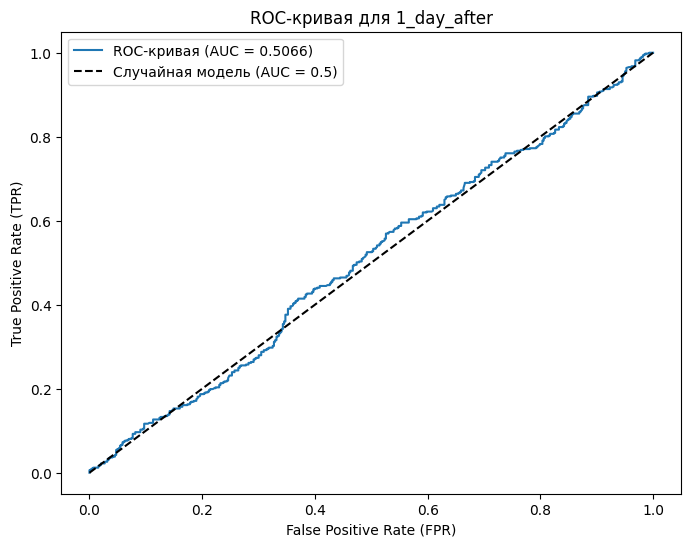

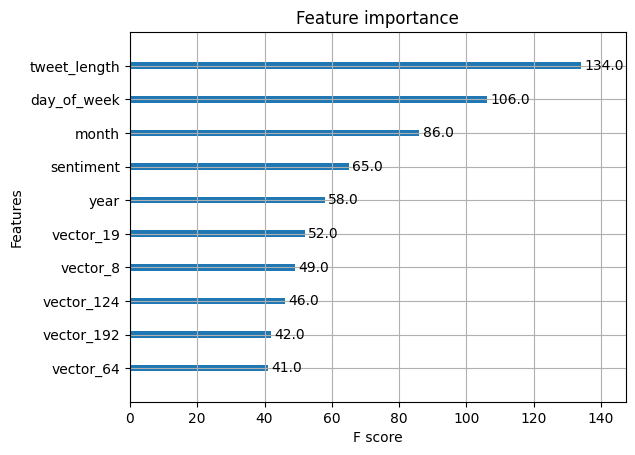

In [15]:
# Разделение данных на обучающую и тестовую выборки
train_mask = df['year'] < 2024
test_mask = df['year'] == 2024
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Обучение модели XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Предсказание вероятностей
y_prob = model.predict_proba(X_test)[:, 1]

# Оценка ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("Для 1_day_after:")
print(f"ROC-AUC: {roc_auc:.4f}")

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая для 1_day_after')
plt.legend()
plt.show()

# Построение графика важности признаков
xgb.plot_importance(model, max_num_features=10)
plt.show()

In [17]:
# Сохранение модели
model.save_model('xgboost_model_1day_new.json')

# Скачивание модели
from google.colab import files
files.download('xgboost_model_1day_new.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Для 1_day_after (с инвертированными предсказаниями):
ROC-AUC: 0.4805


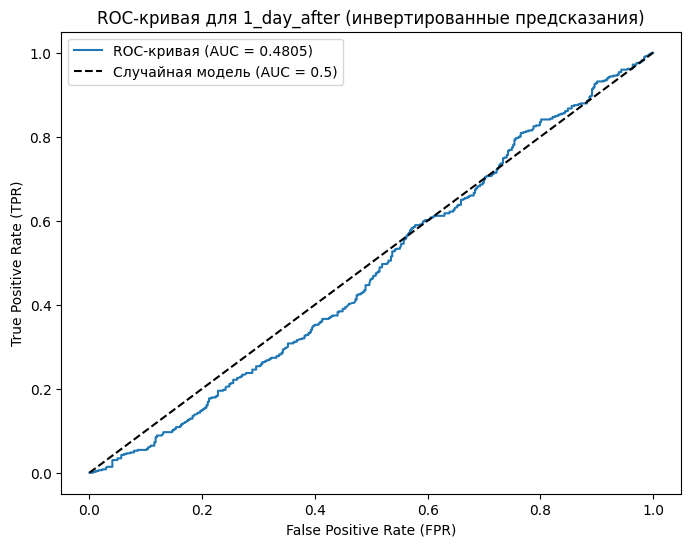

In [14]:
# Инвертирование предсказаний
y_prob_inverted = 1 - y_prob
roc_auc_inverted = roc_auc_score(y_test, y_prob_inverted)
print("Для 1_day_after (с инвертированными предсказаниями):")
print(f"ROC-AUC: {roc_auc_inverted:.4f}")

# ROC-кривая для инвертированных предсказаний
fpr, tpr, thresholds = roc_curve(y_test, y_prob_inverted)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc_inverted:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая для 1_day_after (инвертированные предсказания)')
plt.legend()
plt.show()

In [12]:
# Установка vaderSentiment для анализа сентимента
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Инициализация анализатора сентимента
analyzer = SentimentIntensityAnalyzer()

# Добавляем признак сентимента
df['sentiment'] = df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Добавляем признак длины твита
df['tweet_length'] = df['text'].apply(len)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [13]:
# Объединяем векторы с остальными признаками, включая новые
df_features = pd.concat([vector_df, df[['is_quote_status', 'has_card', 'is_in_reply_to', 'is_urls', 'is_thumbnail_title', 'is_hashtags', 'year', 'month', 'day_of_week', 'sentiment', 'tweet_length']]], axis=1)

# Удаляем дубликаты столбцов, если они есть
df_features = df_features.loc[:, ~df_features.columns.duplicated()]

# Формируем список признаков
features = [col for col in df_features.columns if col.startswith('vector_')] + ['is_quote_status', 'has_card', 'is_in_reply_to', 'is_urls', 'is_thumbnail_title', 'is_hashtags', 'year', 'month', 'day_of_week', 'sentiment', 'tweet_length']
X = df_features[features]
y = df['1_day_after']

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:05:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Для 1_day_after (с настроенными гиперпараметрами):
ROC-AUC: 0.5245


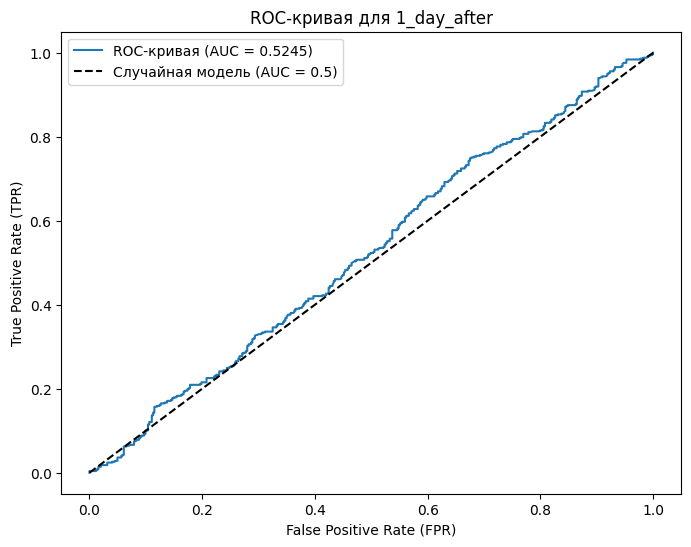

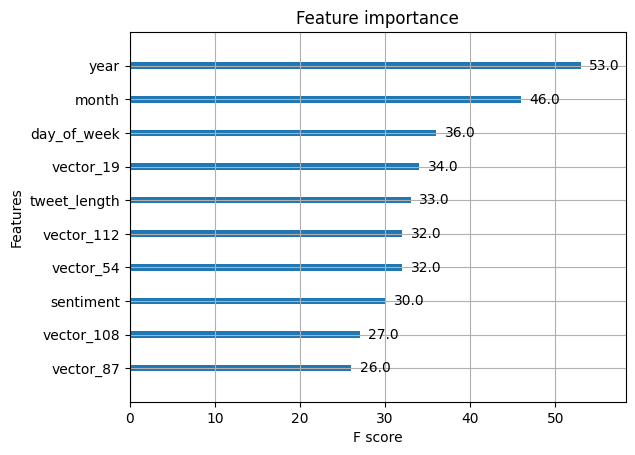

In [16]:
# Разделение данных на обучающую и тестовую выборки
train_mask = df['year'] < 2024
test_mask = df['year'] == 2024
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Обучение модели XGBoost с настроенными гиперпараметрами
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=3,
    learning_rate=0.03,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=2.0
)
model.fit(X_train, y_train)

# Предсказание вероятностей
y_prob = model.predict_proba(X_test)[:, 1]

# Оценка ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("Для 1_day_after (с настроенными гиперпараметрами):")
print(f"ROC-AUC: {roc_auc:.4f}")

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая для 1_day_after')
plt.legend()
plt.show()

# Построение графика важности признаков
xgb.plot_importance(model, max_num_features=10)
plt.show()

Распределение классов в 1_day_after (train):
1_day_after
1    3961
0    3497
Name: count, dtype: int64
Распределение классов в 1_day_after (test):
1_day_after
1    497
0    443
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:06:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Для 1_day_after (с учетом дисбаланса):
ROC-AUC: 0.5200


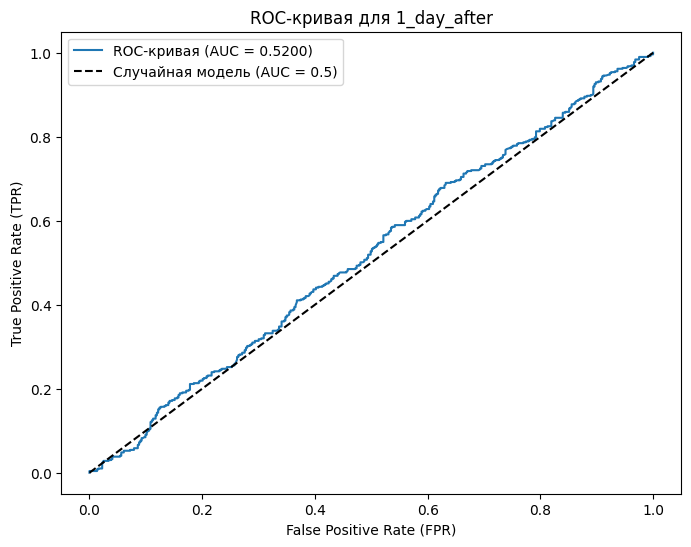

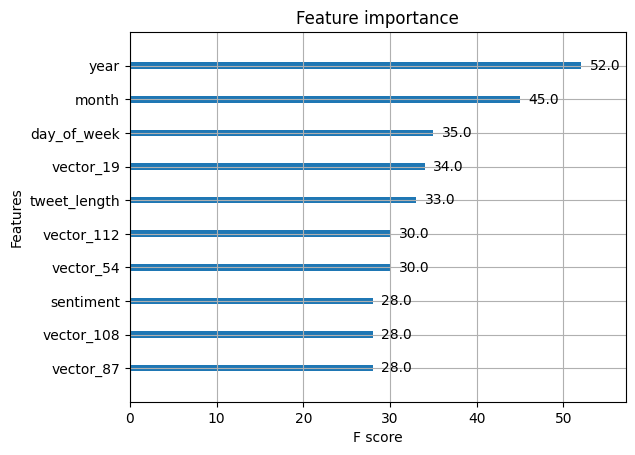

In [18]:
# Проверка распределения классов
print("Распределение классов в 1_day_after (train):")
print(y_train.value_counts())
print("Распределение классов в 1_day_after (test):")
print(y_test.value_counts())

# Вычисление scale_pos_weight
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos if pos > 0 else 1

# Обучение модели XGBoost с учетом дисбаланса
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=3,
    learning_rate=0.03,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=2.0,
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train, y_train)

# Предсказание вероятностей
y_prob = model.predict_proba(X_test)[:, 1]

# Оценка ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("Для 1_day_after (с учетом дисбаланса):")
print(f"ROC-AUC: {roc_auc:.4f}")

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая для 1_day_after')
plt.legend()
plt.show()

# Построение графика важности признаков
xgb.plot_importance(model, max_num_features=10)
plt.show()